# Discrete Fourier Transform

Let's implement a discrete Fourier transform.

We essentially want to code up:

$$F_k = \sum_{n = 0}^{N-1} f_n e^{-2\pi i n k / N}$$

This requires a double sum: for each wavenumber, $k$, we sum over all the spatial points.
This means that the amount of work scales as $\mathcal{O}(N^2)$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def dft(f_n):
    """perform a discrete Fourier transform"""
    
    N = len(f_n)
    n = np.arange(N)
    
    f_k = np.zeros((N), dtype=np.complex128)

    for k in range(N):
        f_k[k] = np.sum(f_n * np.exp(-2.0 * np.pi * 1j * n * k / N))
    return f_k

Notice that in python, the complex unit, $\sqrt{-1}$ is denoted by `j`

Now let's try this out.  Let's compute the transform of 

$$f(x) = \sin(2 \pi \nu_0 x)$$

We would expect to see all of the power at a single frequency $\nu_0$, and since our function is a $\sin()$, we would expect for all of the power to be in the imaginary component.

In [14]:
N = 64
nu_0 = 0.2
xmax = 50.0

x = np.linspace(0.0, xmax, N, endpoint=False)
f_n = np.sin(2.0 * np.pi * nu_0 * x)

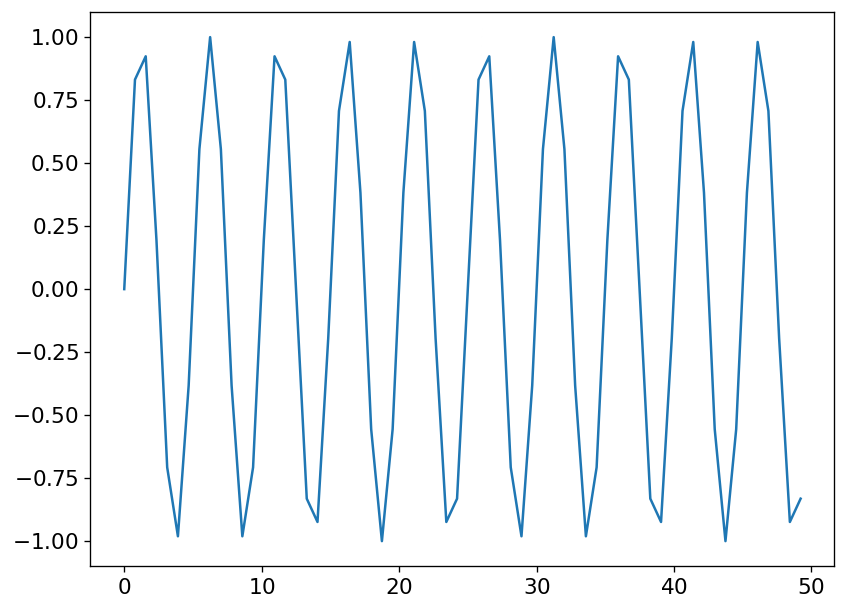

In [15]:
fig, ax = plt.subplots()
ax.plot(x, f_n)

Now the DFT

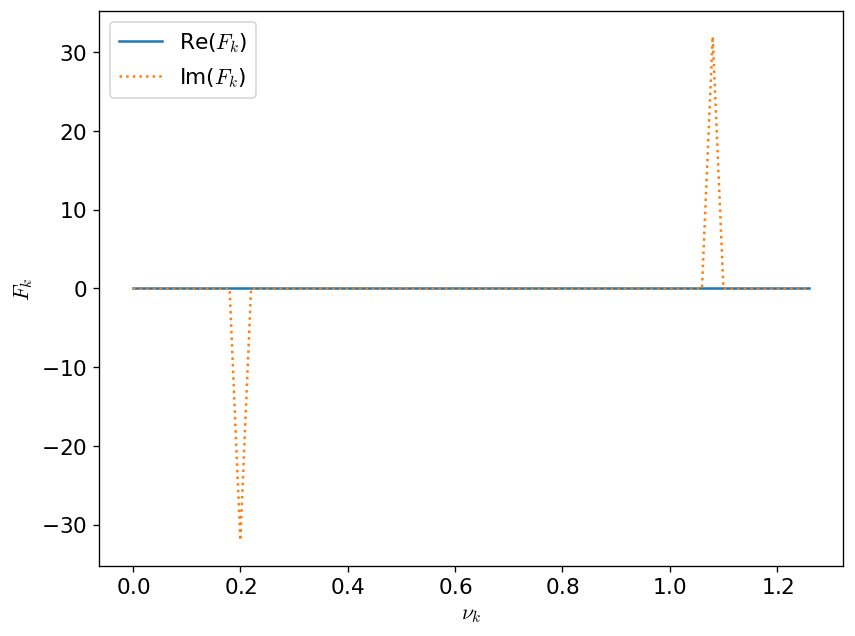

In [17]:
f_k = dft(f_n)
nu_k = np.arange(N) / xmax

fig, ax = plt.subplots()
ax.plot(nu_k, f_k.real, label=r"Re($F_k$)")
ax.plot(nu_k, f_k.imag, ls=":", label=r"Im($F_k$)")

ax.set_xlabel(r"$\nu_k$")
ax.set_ylabel(r"$F_k$")
ax.legend()

As expected, all of the power is in the imaginary part, and it looks like it is at a frequency of $\nu = 0.2$, as we expected.  But there are 2 peaks.

We now need to discuss this following:

* How did we compute the physical frequency, $\nu_k$, corresponding to each frequency sample?
* Why are there 2 peaks in our transform?
* What is the significance of the amplitudes in this plot?

## Frequency

We want to understand how to get a physical frequency from the data.

Note: in the DFT, the physical coordinate value, $x_n$, does not enter&mdash;instead we just look at the index `n` itself.

Consider our single-mode sine wave.  We can express it as:

$$\sin(2\pi \nu x) =  \sin \left ( \frac{2\pi k x}{L} \right ) = \sin \left ( \frac{2\pi k n}{N} \right )$$

where $L$ is the maximum extent of the coordinate $x$ (if $x$ represents time, then this would be the maximum time for the data), and $n$ is the index of the discrete data.
They are related via

$$x_n = \frac{n L}{N}$$

![various single mode sine waves](sine-k.png)

From this plot, we see that if there is a single mode in the domain, associated with the wavenumber `1`, then the physical frequency is $1/L$.

And in general, $\nu = k/L$ for $k = 0, 1, 2, \ldots N-1$.

Most DFT routines will return frequencies in index space, e.g.,

$$k_\mathrm{freq} = 0, 1/N, 2/N, 3/N, \ldots$$

* In this index space, the smallest wavelength is from one cell to the next, and the corresponding frequency is $1/N$
* This means that as we add points to our data, then we open up higher-and-higher frequencies (in terms of index space)

Clearly then the physical scale for the frequency is:

$$\nu_k = \underbrace{\left ( \frac{k}{N} \right )}_{k_\mathrm{freq}} \cdot \frac{1}{\Delta x} = \left (\frac{k}{N} \right ) \cdot \frac{N}{L} = \frac{k}{L}$$

* lowest frequency: $1/L$, corresponds to the largest wavelength, e.g., the entire domain
* highest frequency: $N/L \sim 1/\Delta x$, corresponds to the shortest wavelength, one sample to the next


Following this procedure, the physical frequency for our DFT above is found simply via:
    
```
nu_k = np.arange(N) / xmax
```

### Nyquist frequency

The highest meaningful frequecy is $1/(2 \Delta x)$ which is called the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency).

Consider a timeseries with 10 samples that goes for 10 s.  So $\Delta t = 1 s$.  The Nyquist frequency would be $\nu_\mbox{Nyquist} = 1/(2 \Delta t) = 0.5~\mbox{Hz}$.

Using our prescription above, the frequencies are:

$$\nu_k = 0, \frac{1}{10~\mbox{s}}, \frac{2}{10~\mbox{s}}, \frac{3}{10~\mbox{s}}, \frac{4}{10~\mbox{s}}, {\color{red}\frac{5}{10~\mbox{s}}}, \frac{6}{10~\mbox{s}}, \frac{7}{10~\mbox{s}}, \frac{8}{10~\mbox{s}}, \frac{9}{10~\mbox{s}}$$

where we highlight the Nyquist frequency in red.

These are equivalent to

$$\nu_k = 0, 0.1~\mbox{Hz}, 0.2~\mbox{Hz}, 0.3~\mbox{Hz}, 0.4~\mbox{Hz}, {\color{red} 0.5~\mbox{Hz}}, 0.6~\mbox{Hz}, 0.7~\mbox{Hz}, 0.8~\mbox{Hz}, 0.9~\mbox{Hz}$$

Let's look at what happens when we try to represent a sine wave with 10 points at these different frequencies:

In [1]:
def f_sin(t, nu):
    return np.sin(2 * np.pi * nu * t)

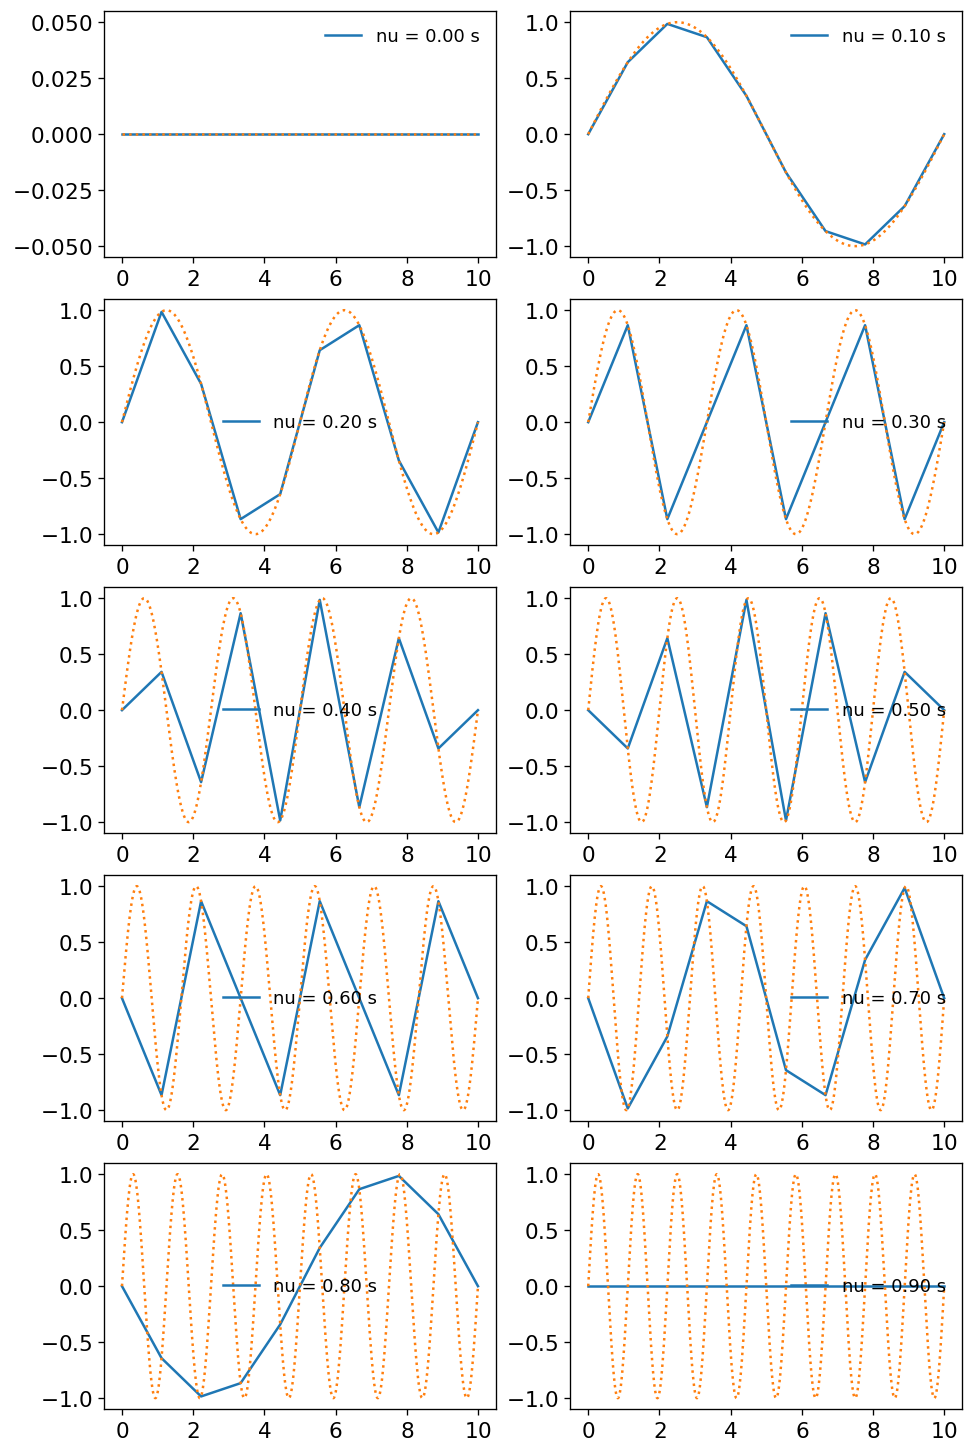

In [25]:
fig, axs = plt.subplots(nrows=5, ncols=2, layout="constrained", figsize=(8, 12))

t = np.linspace(0, 10, 10)
tt = np.linspace(0, 10, 1000)

for n, ax in enumerate(axs.flat):
    nu = 0.1 * n
    ax.plot(t, f_sin(t, nu), label=f"nu = {nu:4.2f} s")
    ax.plot(tt, f_sin(tt, nu), linestyle=":")
    ax.legend(frameon=False, fontsize="small")
    ax.set_xlabel="time (s)"


We see that once we go past the Nyquist frequency, we no longer resolve the correct number of wave peaks.  This is an example of [_aliasing_](https://en.wikipedia.org/wiki/Aliasing)

## Why 2 peaks?

Both the real-space and frequency-space forms of the function contain the same information.  In our `dft()` function above, we had N real values and return N complex values,
but each complex number has twice the amount of information as a single real number.  This means that half of the complex numbers we return are not independent.

This is a consequence of the fact that for an analytic Fourier transform of a real function, $f(x)$, $F(-k) = F^*(k)$.  In the discrete transform, this shows itself as:

$$F_{N-k} = F_k^\star$$

we can see this as:

$$F_{N-k} = \sum_{n=0}^{N-1} f_n e^{-2\pi i n (N-k)/N} = \sum_{n=0}^{N-1} f_n e^{+2\pi i n k/N} \underbrace{e^{-2\pi i n}}_{=1} = F_k^\star$$

So only the first $N/2$ points we get from our DFT routine are important.  The others don't add any new information.  This will also affect the normalization (as discussed below).

The also means that the maximum frequency is $1/(2\Delta x)$.

## How do we interpret the amplitude?

When plotting, we want to put the physical scale back in, as well as make the correspondence to the continuous representation.

We can rewrite the inverse DFT expression as:

$$f_n = \frac{1}{N} \sum_{n=0}^{N-1} F_k e^{2\pi i n k /N} 
= \underbrace{\sum_{n=0}^{N-1} \overbrace{\left (\frac{F_k}{N} \right )}^{\substack{\mbox{this is what}\\ \mbox{we plot}}}
e^{2\pi i n k /N}}_{\mbox{this looks like the continuous form}} $$

* This suggests that we should normalize the $F_k$ by the number of points, $N$.
* Another interpretation relates to the continuous form of the Fourier transform: $F_k / N \Longleftrightarrow F_k dk$


## Power spectrum

The power spectrum is defined simply as

$$P(k) = |F(k)|^2 = F(k) F^\star(k)$$

This is a single number that shows the importance / weight of a given frequency

## C++ Implementation

A C++ implementation is available at: https://github.com/zingale/computational_astrophysics/tree/main/examples/fft